In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import mne
from mne_connectivity import spectral_connectivity_epochs
from spectral_connectivity import Multitaper, Connectivity
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import time
from matplotlib.patches import FancyArrowPatch
from scipy.stats import f_oneway
#from my_networkx import my_draw_networkx_edge_labels
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [ ]:
#DEFINING FUNCTIONS

In [2]:
scenario_list = ['scenario_1', 'scenario_2', 'scenario_3']

def simulate_scenario(scenario):
    sfreq = 250 # Hz
    tmin = 0 # s
    tmax = 100 # s
    time = np.arange(tmin, tmax, 1/sfreq) 

    f1 = np.random.randint(1,41)  #literature value = 0.125
    f2 = np.random.randint(1,41)   #literature value = 0.25
    f3 = np.random.randint(1,41)  #literature value = 0.10

    signal1 = np.sin(2*np.pi*f1*time)
    signal2 = np.sin(2*np.pi*f2*time)
    signal3 = np.sin(2*np.pi*f3*time)

    #np.random.seed(1000)
    noise1 = np.random.randn(len(time))
    noise2 = np.random.randn(len(time))
    noise3 = np.random.randn(len(time))

     #gains
    g1 = g2 = g3 = 1

    alpha1 = np.random.uniform(0.01, 0.5)
    alpha2 = np.random.uniform(0.01, 0.5)
    alpha3 = np.random.uniform(0.01, 0.5)

    snr1 = g1/alpha1
    snr2 = g2/alpha2
    snr3 = g3/alpha3

    #in radians  #randomize between 0 and 2pi, uniformly distributed
    phase_3_1 = np.random.uniform(0,2)*np.pi
    phase_3_2 = np.random.uniform(0,2)*np.pi
    phase_1_2 = np.random.uniform(0,2)*np.pi

    #delays in seconds
    tau3_1 = phase_3_1/(2*np.pi*f1) #from 3 to 1
    tau3_2 = phase_3_2/(2*np.pi*f2) #from 3 to 2
    tau1_2 = phase_1_2/(2*np.pi*f3) #from 1 to 2
    
    #Time lags in samples
    lag3_1 = np.int64(np.round(tau3_1*f1))
    lag3_2 = np.int64(np.round(tau3_2*f2))
    lag1_2 = np.int64(np.round(tau1_2*f3))

    coefficient_dict = {'scenario_1':{'c_3_1': 1, 'c_3_2':1, 'c_1_2':0},
                        'scenario_2':{'c_3_1': 1, 'c_3_2':0, 'c_1_2':1},
                        'scenario_3':{'c_3_1': 0, 'c_3_2': 0, 'c_1_2':0}}

    c_3_1 = coefficient_dict[scenario]['c_3_1']
    c_3_2 = coefficient_dict[scenario]['c_3_2']
    c_1_2 = coefficient_dict[scenario]['c_1_2']
    
    y3 = (g1*signal3) + noise3*snr3
    y1 = (g2*signal1) + noise1*snr1 + c_3_1*np.roll(y3, lag3_1)
    y2 = (g3*signal2) + noise2*snr2 + c_3_2*np.roll(y3, lag3_2) + c_1_2*np.roll(y1, lag1_2)

    if scenario == 'scenario_3':
        L = np.random.uniform(-1,1,size=(3,3))
    else:
        L = np.identity(3)
    

    z1, z2, z3 = L @ np.array([y1, y2, y3])

    return[z1, z2, z3]

In [3]:
def simulated_raw(signals):
    sim_data = np.array(signals)
    info = mne.create_info(ch_names=["y1", "y2", "y3"], ch_types=["eeg"]*3, sfreq=250)
    simulated_raw = mne.io.RawArray(sim_data, info)
    return simulated_raw

In [4]:
def estimate_conn_undirected(method, data):
    epochs_1 = mne.make_fixed_length_epochs(simulated_raw(data), duration=1)
    
    mne_con = spectral_connectivity_epochs(epochs_1, method=method, sfreq=250, fmin=8, fmax=13, 
                                           fskip=0, faverage=False,
                                           mt_low_bias=True, block_size=1000, n_jobs=1, 
                                           verbose=None)
    con_mat = mne_con.get_data(output="dense")
    con_mat_normalized = (con_mat - con_mat.min())/(con_mat.max() - con_mat.min())
    return con_mat_normalized

In [5]:
def estimate_conn_directed(method, data):
    epochs_2 = mne.make_fixed_length_epochs(simulated_raw(data), duration=8)
    
    m = Multitaper(time_series=np.array(epochs_2.get_data()).transpose(2, 0, 1), sampling_frequency=250)
    c = Connectivity(fourier_coefficients=m.fft(), frequencies=m.frequencies, time=m.time)    
    con = getattr(c, method)()
    con_mat = np.nan_to_num(con.squeeze())[80:131].transpose(1,2,0)
    con_mat_normalized = (con_mat - con_mat.min())/(con_mat.max() - con_mat.min())
    return con_mat_normalized

In [ ]:
#DEFINING GROUND TRUTHS AND METHODS

In [6]:
#format: (1,2),(1,3),(2,3)
#'scenario_1B':np.array([1,1,1]), 'scenario_2B':np.array([1,1,1])

ground_truth_dict = {'scenario_1':np.array([[0,0,0],
                                                 [0,0,0],
                                                 [1,1,0]]),
                     'scenario_2':np.array([[0,0,0],
                                            [1,0,0],
                                            [1,0,0]]),
                     'scenario_3':np.array([[0,0,0],
                                            [0,0,0],
                                            [0,0,0]])}
undirected_methods = ['coh', 'ciplv','imcoh','wpli2_debiased']

directed_methods = ['generalized_partial_directed_coherence', 
                    'direct_directed_transfer_function', 
                    'pairwise_spectral_granger_prediction']

In [ ]:
#TOPOLOGY ESTIMATES

In [ ]:
#Undirected methods

In [ ]:
#getting edge estimates

In [7]:
%%capture
edge_lists_undirected = {}
for scenario in scenario_list:
    edge_lists = {}
    for method in undirected_methods:
        edges_list = []
        for i in range(100):
            con_mat = estimate_conn_undirected(method,simulate_scenario(scenario))
            edges = [round(con_mat.mean(2)[1][0],2), round(con_mat.mean(2)[2][1],2), round(con_mat.mean(2)[2][0],2)]
            edges_list.append(edges)
        mean_edges = np.array(edges_list)
        edge_lists[method] = np.round(mean_edges.mean(axis=0),2)
    edge_lists_undirected[scenario] = edge_lists

In [8]:
edge_lists_undirected

{'scenario_1': {'coh': array([0.58, 0.8 , 0.88]),
  'ciplv': array([0.39, 0.55, 0.56]),
  'imcoh': array([0.28, 0.58, 0.61]),
  'wpli2_debiased': array([0.35, 0.5 , 0.41])},
 'scenario_2': {'coh': array([0.86, 0.53, 0.74]),
  'ciplv': array([0.54, 0.57, 0.57]),
  'imcoh': array([0.21, 0.69, 0.66]),
  'wpli2_debiased': array([0.48, 0.5 , 0.44])},
 'scenario_3': {'coh': array([0.67, 0.72, 0.74]),
  'ciplv': array([0.45, 0.45, 0.44]),
  'imcoh': array([0.47, 0.49, 0.53]),
  'wpli2_debiased': array([0.3 , 0.33, 0.34])}}

In [9]:
edge_list_1 = [('X','Y',{'w':'A1'}),('Y','Z',{'w':'B1'}),('X','Z',{'w':'C1'})]

edge_list_2 = [('Y','X',{'w':'A2'}),('Z','Y',{'w':'B2'}),('Z','X',{'w':'C2'})]

### Scenario 1

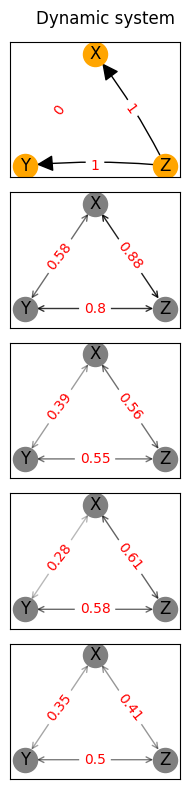

In [20]:
fig, axes = plt.subplots(5,1,figsize=(2,8))

G = nx.DiGraph()

G.add_edges_from(edge_list_1)
pos=nx.spring_layout(G,seed=5)
pos = nx.shell_layout(G,rotate=np.pi/2)
arc_rad = 0.05
nx.draw_networkx_edges(G, pos, ax=axes[0], edgelist=edge_list_1, connectionstyle=f'arc3, rad = {arc_rad}',alpha=[0,0,0],arrowsize=25)
nx.draw_networkx_edges(G, pos, ax=axes[0], edgelist=edge_list_2, connectionstyle=f'arc3, rad = {arc_rad}',alpha=[0,1,1],arrowsize=25)
nx.draw_networkx_edge_labels(G, pos, ax=axes[0], edge_labels={('Y','X'):0,('Z','Y'):1,('Z','X'):1},font_color='red')
nx.draw_networkx_nodes(G, pos, ax=axes[0],node_color='orange',alpha=1.0)
nx.draw_networkx_labels(G, pos, ax=axes[0])
#axes[0].set_title('Common input confounder',fontsize=11)

for ax,method in zip(list(range(1,5)),undirected_methods):
    G = nx.DiGraph()
    edge_list = [('X','Y',{'w':'A1'}),
                 ('Y','Z',{'w':'B1'}),
                 ('X','Z',{'w':'C1'})]
    G.add_edges_from(edge_list)
    pos = nx.spring_layout(G,seed=5)
    pos = nx.shell_layout(G, rotate=np.pi/2, scale=0.1)
    
    alpha = edge_lists_undirected['scenario_1'][method]
    nx.draw_networkx_edges(G, pos, ax=axes[ax], edgelist=edge_list, alpha=alpha,arrowstyle='<->')
    nx.draw_networkx_edge_labels(G, pos, ax=axes[ax], edge_labels={('X','Y'):alpha[0],('Y','Z'):alpha[1],('X','Z'):alpha[2]},font_color='red')
    arc_rad = 0.05
    nx.draw_networkx_nodes(G, pos, ax=axes[ax], node_color='grey',alpha=1.0)
    nx.draw_networkx_labels(G, pos, ax=axes[ax])


fig.suptitle('    Dynamic system')
fig.tight_layout()
plt.savefig('figs/sim_topo_func_comm_dyn.png',dpi=300)

### Volume conduction

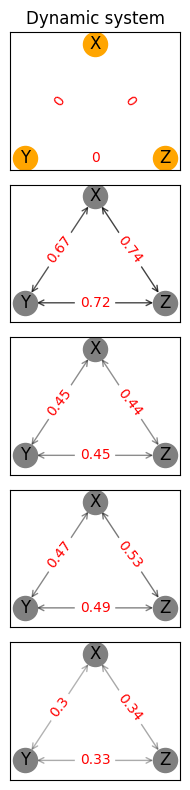

In [24]:
fig, axes = plt.subplots(5,1,figsize=(2,8))

G = nx.Graph()
edge_list = [('X','Y',{'w':'A1'}),
             ('Y','Z',{'w':'B1'}),
             ('X','Z',{'w':'C1'})]
G.add_edges_from(edge_list)
pos = nx.spring_layout(G,seed=5)
pos = nx.shell_layout(G, rotate=np.pi/2, scale=0.1)
nx.draw_networkx_edges(G, pos, ax=axes[0], edgelist=edge_list, alpha=[0,0,0])
arc_rad = 0.05
nx.draw_networkx_edge_labels(G, pos, ax=axes[0], edge_labels={('Y','X'):0,('Z','Y'):0,('Z','X'):0},font_color='red')
nx.draw_networkx_nodes(G, pos, ax=axes[0], node_color='orange',alpha=1.0)
nx.draw_networkx_labels(G, pos, ax=axes[0])


for ax,method in zip(list(range(1,5)),undirected_methods):
    G = nx.DiGraph()
    edge_list = [('X','Y',{'w':'A1'}),
                 ('Y','Z',{'w':'B1'}),
                 ('X','Z',{'w':'C1'})]
    G.add_edges_from(edge_list)
    pos = nx.spring_layout(G,seed=5)
    pos = nx.shell_layout(G, rotate=np.pi/2, scale=0.1)
    
    alpha = edge_lists_undirected['scenario_3'][method]
    nx.draw_networkx_edges(G, pos, ax=axes[ax], edgelist=edge_list, alpha=alpha,arrowstyle='<->')
    nx.draw_networkx_edge_labels(G, pos, ax=axes[ax], edge_labels={('X','Y'):alpha[0],('Y','Z'):alpha[1],('X','Z'):alpha[2]},font_color='red')
    arc_rad = 0.05
    nx.draw_networkx_nodes(G, pos, ax=axes[ax], node_color='grey',alpha=1.0)
    nx.draw_networkx_labels(G, pos, ax=axes[ax])

axes[0].set_title('Dynamic system')

fig.tight_layout()
plt.savefig('figs/sim_topo_func_vol_dyn.png',dpi=300)

In [ ]:
#Directed methods

In [ ]:
#getting edge estimates - #define function to plot edge values in subplots for figures

In [7]:
%%capture
edge_lists_directed = {}
for scenario in scenario_list:
    edge_lists = {}
    for method in directed_methods:
        edges_list = []
        for i in range(100):
            con_mat = estimate_conn_directed(method,simulate_scenario(scenario))
            edges = [round((con_mat.mean(2)[1][0]),2), round((con_mat.mean(2)[2][1]),2), round((con_mat.mean(2)[2][0]),2),round((con_mat.mean(2)[0][1]),2),round((con_mat.mean(2)[1][2]),2), round((con_mat.mean(2)[0][2]),2)]
            edges_list.append(edges)
        mean_edges = np.array(edges_list)
        edge_lists[method] = np.round(mean_edges.mean(axis=0),2)
        
    edge_lists_directed[scenario] = edge_lists

{'X': Text(-4.371138828673793e-08, 1.0, 'X'),
 'Y': Text(-0.8660253286361694, -0.5000001788139343, 'Y'),
 'Z': Text(0.8660255670547485, -0.4999997615814209, 'Z')}

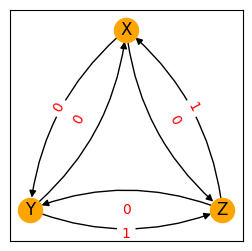

In [8]:
fig, axes = plt.subplots(1,1,figsize=(3,3))

G = nx.DiGraph()

edge_list_1 = [('X','Y',{'w':'A1'}),('Y','Z',{'w':'B1'}),('X','Z',{'w':'C1'})]
edge_list_2 = [('Y','X',{'w':'A2'}),('Z','Y',{'w':'B2'}),('Z','X',{'w':'C2'})]

G.add_edges_from(edge_list_1)
G.add_edges_from(edge_list_2)

pos1 = nx.shell_layout(G,rotate=np.pi/2)
pos2 = nx.shell_layout(G,rotate=np.pi/2,scale=1.4)
#pos2 = nx.shell_layout(G,rotate=np.pi/2,scale=1.6)

arc_rad = 0.2

nx.draw_networkx_edges(G, pos1, ax=axes, edgelist=edge_list_1,alpha=[1,1,1],connectionstyle=f'arc3, rad = {arc_rad}')
nx.draw_networkx_edges(G, pos1, ax=axes, edgelist=edge_list_2,alpha=[1,1,1],connectionstyle=f'arc3, rad = {arc_rad}')

nx.draw_networkx_edge_labels(G, pos1, ax=axes, edge_labels={('X','Y'):0,('Y','Z'):0,('X','Z'):0},font_color='red')
nx.draw_networkx_edge_labels(G, pos2, ax=axes, edge_labels={('Y','X'):0,('Z','Y'):1,('Z','X'):1},font_color='red')

nx.draw_networkx_nodes(G, pos1, ax=axes,node_color='orange',alpha=1.0)
nx.draw_networkx_labels(G, pos1, ax=axes)

#nx.draw_networkx_edges(G, pos, ax=axes[0], edgelist=edge_list_1, connectionstyle=f'arc3, rad = {arc_rad}',alpha=[0,0,0],arrowsize=25)
#nx.draw_networkx_edges(G, pos, ax=axes[0], edgelist=edge_list_2, connectionstyle=f'arc3, rad = {arc_rad}',alpha=[0,1,1],arrowsize=25)

#nx.draw_networkx_edge_labels(G, pos, ax=axes, edge_labels={('Y','X'):0,('Z','Y'):1,('Z','X'):1},font_color='red')



### Scenario 1

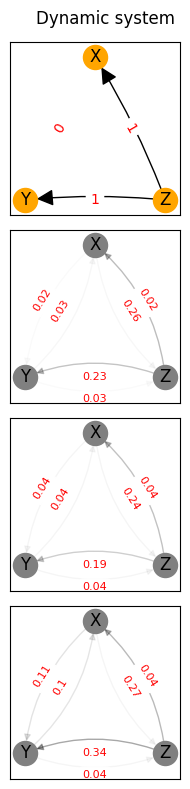

In [11]:
fig, axes = plt.subplots(4,1,figsize=(2,8))

G = nx.DiGraph()

G.add_edges_from(edge_list_1)

pos = nx.shell_layout(G,rotate=np.pi/2)
arc_rad = 0.05
nx.draw_networkx_edges(G, pos, ax=axes[0], edgelist=edge_list_1, connectionstyle=f'arc3, rad = {arc_rad}',alpha=[0,0,0],arrowsize=25)
nx.draw_networkx_edges(G, pos, ax=axes[0], edgelist=edge_list_2, connectionstyle=f'arc3, rad = {arc_rad}',alpha=[0,1,1],arrowsize=25)
nx.draw_networkx_edge_labels(G, pos, ax=axes[0], edge_labels={('Y','X'):0,('Z','Y'):1,('Z','X'):1},font_color='red')
nx.draw_networkx_nodes(G, pos, ax=axes[0],node_color='orange',alpha=1.0)
nx.draw_networkx_labels(G, pos, ax=axes[0])


for ax,method in zip(list(range(1,4)),directed_methods):
    alpha = edge_lists_directed['scenario_1'][method]
    G = nx.DiGraph()
    edge_list_1 = [('X','Y',{'w':'A1'}),('Y','Z',{'w':'B1'}),('X','Z',{'w':'C1'})]
    edge_list_2 = [('Y','X',{'w':'A2'}),('Z','Y',{'w':'B2'}),('Z','X',{'w':'C2'})]
    
    G.add_edges_from(edge_list_1)
    G.add_edges_from(edge_list_2)
    
    pos1 = nx.shell_layout(G,rotate=np.pi/2)
    pos2 = nx.shell_layout(G,rotate=np.pi/2,scale=1.5)

    arc_rad = 0.2
    curved_edges = [edge for edge in G.edges() if reversed(edge) in G.edges()]
    nx.draw_networkx_edges(G, pos1, ax=axes[ax], edgelist=curved_edges,alpha=[alpha[0],alpha[1],alpha[2],alpha[3],alpha[4],alpha[5]],connectionstyle=f'arc3, rad = {arc_rad}')

    nx.draw_networkx_edge_labels(G, pos2, ax=axes[ax], edge_labels={('X','Y'):alpha[0],('Y','Z'):alpha[1],('X','Z'):alpha[2]}, font_size=8, font_color='red')
    nx.draw_networkx_edge_labels(G, pos1, ax=axes[ax], edge_labels={('Y','X'):alpha[3],('Z','Y'):alpha[4],('Z','X'):alpha[5]},font_size=8, font_color='red')
    
    nx.draw_networkx_nodes(G, pos1, ax=axes[ax],node_color='grey')
    nx.draw_networkx_labels(G, pos1, ax=axes[ax])

    

fig.suptitle('    Dynamic system')
fig.tight_layout()
plt.savefig('figs/sim_topo_eff_comm_dyn.png')

### Scenario 2

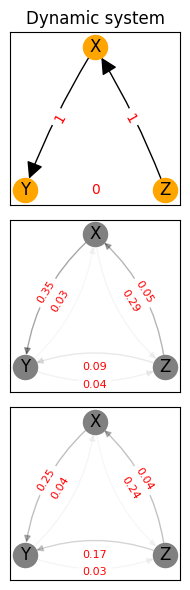

In [45]:
fig, axes = plt.subplots(3,1,figsize=(2,6))

G = nx.DiGraph()
edge_list_1 = [('X','Y',{'w':'A1'}),('Y','Z',{'w':'B1'}),('X','Z',{'w':'C1'})]

edge_list_2 = [('Y','X',{'w':'A2'}),('Z','Y',{'w':'B2'}),('Z','X',{'w':'C2'})]

G.add_edges_from(edge_list_1)
G.add_edges_from(edge_list_2)
pos=nx.spring_layout(G,seed=5)
pos = nx.shell_layout(G,rotate=np.pi/2)
arc_rad = 0.05
nx.draw_networkx_edges(G, pos, ax=axes[0], edgelist=edge_list_1, connectionstyle=f'arc3, rad = {arc_rad}',alpha=[1,0,0],arrowsize=25)
nx.draw_networkx_edges(G, pos, ax=axes[0], edgelist=edge_list_2, connectionstyle=f'arc3, rad = {arc_rad}',alpha=[0,0,1],arrowsize=25)
nx.draw_networkx_edge_labels(G, pos, ax=axes[0], edge_labels={('Y','X'):1,('Z','Y'):0,('Z','X'):1},font_color='red')
nx.draw_networkx_nodes(G, pos, ax=axes[0],node_color='orange',alpha=1.0)
nx.draw_networkx_labels(G, pos, ax=axes[0])

for ax,method in zip(list(range(1,4)),['generalized_partial_directed_coherence','direct_directed_transfer_function']):
    alpha = edge_lists_directed['scenario_2'][method]
    G = nx.DiGraph()
    edge_list_1 = [('X','Y',{'w':'A1'}),('Y','Z',{'w':'B1'}),('X','Z',{'w':'C1'})]
    edge_list_2 = [('Y','X',{'w':'A2'}),('Z','Y',{'w':'B2'}),('Z','X',{'w':'C2'})]
    
    G.add_edges_from(edge_list_1)
    G.add_edges_from(edge_list_2)
    
    pos1 = nx.shell_layout(G,rotate=np.pi/2)
    pos2 = nx.shell_layout(G,rotate=np.pi/2,scale=1.4)

    arc_rad = 0.2
    curved_edges = [edge for edge in G.edges() if reversed(edge) in G.edges()]
    nx.draw_networkx_edges(G, pos1, ax=axes[ax], edgelist=curved_edges,alpha=[alpha[0],alpha[1],alpha[2],alpha[3],alpha[4],alpha[5]],connectionstyle=f'arc3, rad = {arc_rad}')

    nx.draw_networkx_edge_labels(G, pos2, ax=axes[ax], edge_labels={('X','Y'):alpha[0],('Y','Z'):alpha[1],('X','Z'):alpha[2]}, font_size=8, font_color='red')
    nx.draw_networkx_edge_labels(G, pos1, ax=axes[ax], edge_labels={('Y','X'):alpha[3],('Z','Y'):alpha[4],('Z','X'):alpha[5]},font_size=8, font_color='red')
    
    nx.draw_networkx_nodes(G, pos1, ax=axes[ax],node_color='grey')
    nx.draw_networkx_labels(G, pos1, ax=axes[ax])

axes[0].set_title('Dynamic system')

#fig.suptitle('         Dynamic system')
fig.tight_layout()
plt.savefig('figs/sim_topo_eff_ind_dyn.png',dpi=300)

### Scenario 3

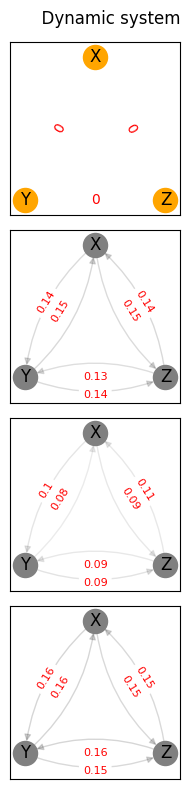

In [49]:
fig, axes = plt.subplots(4,1,figsize=(2,8))

G = nx.Graph()
edge_list = [('X','Y',{'w':'A1'}),
             ('Y','Z',{'w':'B1'}),
             ('X','Z',{'w':'C1'})]
G.add_edges_from(edge_list)
pos = nx.spring_layout(G,seed=5)
pos = nx.shell_layout(G, rotate=np.pi/2, scale=0.1)
nx.draw_networkx_edges(G, pos, ax=axes[0], edgelist=edge_list, alpha=[0,0,0])
arc_rad = 0.05
nx.draw_networkx_edge_labels(G, pos, ax=axes[0], edge_labels={('Y','X'):0,('Z','Y'):0,('Z','X'):0},font_color='red')
nx.draw_networkx_nodes(G, pos, ax=axes[0], node_color='orange',alpha=1.0)
nx.draw_networkx_labels(G, pos, ax=axes[0])

for ax,method in zip(list(range(1,4)),directed_methods):
    alpha = edge_lists_directed['scenario_3'][method]
    G = nx.DiGraph()
    edge_list_1 = [('X','Y',{'w':'A1'}),('Y','Z',{'w':'B1'}),('X','Z',{'w':'C1'})]
    edge_list_2 = [('Y','X',{'w':'A2'}),('Z','Y',{'w':'B2'}),('Z','X',{'w':'C2'})]
    
    G.add_edges_from(edge_list_1)
    G.add_edges_from(edge_list_2)
    
    pos1 = nx.shell_layout(G,rotate=np.pi/2)
    pos2 = nx.shell_layout(G,rotate=np.pi/2,scale=1.4)

    arc_rad = 0.2
    curved_edges = [edge for edge in G.edges() if reversed(edge) in G.edges()]
    nx.draw_networkx_edges(G, pos1, ax=axes[ax], edgelist=curved_edges,alpha=[alpha[0],alpha[1],alpha[2],alpha[3],alpha[4],alpha[5]],connectionstyle=f'arc3, rad = {arc_rad}')

    nx.draw_networkx_edge_labels(G, pos2, ax=axes[ax], edge_labels={('X','Y'):alpha[0],('Y','Z'):alpha[1],('X','Z'):alpha[2]}, font_size=8, font_color='red')
    nx.draw_networkx_edge_labels(G, pos1, ax=axes[ax], edge_labels={('Y','X'):alpha[3],('Z','Y'):alpha[4],('Z','X'):alpha[5]},font_size=8, font_color='red')
    
    nx.draw_networkx_nodes(G, pos1, ax=axes[ax],node_color='grey')
    nx.draw_networkx_labels(G, pos1, ax=axes[ax])


fig.suptitle('      Dynamic system')
fig.tight_layout()
plt.savefig('figs/sim_topo_eff_vol_dyn.png')